# House Prices - Advanced Regression Techniques
*Predict sales prices and practice feature engineering, RFs, and gradient boosting*

In [487]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetics for the plots
sns.set(style="whitegrid", palette="muted")

RANDOM_STATE = 101

# pd.set_option('display.precision', 2)

### Data collection

In [488]:
df_train = pd.read_csv("./data/train.csv")
pd.concat([df_train.head(2), df_train.tail(2)])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


### EDA

In [489]:
df_train.shape

(1460, 81)

In [490]:
def show_missing_data(df):
    """
    Display number and percentage of columns with any missing value
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (
        ((df.isnull().sum() / df.isnull().count()) * 100)
        .sort_values(ascending=False)
        .round(2)
    )
    missing_data = pd.concat([total, percent], axis=1, keys=["# missing", "% missing"])
    print(missing_data[missing_data["# missing"] > 0])


show_missing_data(df_train)

              # missing  % missing
PoolQC             1453      99.52
MiscFeature        1406      96.30
Alley              1369      93.77
Fence              1179      80.75
MasVnrType          872      59.73
FireplaceQu         690      47.26
LotFrontage         259      17.74
GarageYrBlt          81       5.55
GarageCond           81       5.55
GarageType           81       5.55
GarageFinish         81       5.55
GarageQual           81       5.55
BsmtFinType2         38       2.60
BsmtExposure         38       2.60
BsmtQual             37       2.53
BsmtCond             37       2.53
BsmtFinType1         37       2.53
MasVnrArea            8       0.55
Electrical            1       0.07


- `PoolQC`=NA means no pool
- `MiscFeature`=NA means there are no extra features (e.g.: Elevator, Tennis Court..)
- `Alley`=NA means no alley access
- `Fence`=NA means no fence
- `MasVnrType`=NA means None
- `FireplaceQu`=NA means no Fireplace
- `LotFrontage` with 18% missing records.  Relevant/can be infered?
- There are 12 features with missing values than need handling

In [491]:
# only 1 value different -> to be discarded!
df_train['Utilities'].value_counts()

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

In [492]:
# only 6 values different -> to be discarded!
df_train['Street'].value_counts()

Street
Pave    1454
Grvl       6
Name: count, dtype: int64

In [493]:
# only 6 values different -> to be discarded!
df_train['PoolQC'].value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

In [494]:
# Correlation of GarageYrBlt with YearBuilt and YearRemodAdd
df_train[
    [
        "GarageYrBlt",
        "YearBuilt",
        "YearRemodAdd",
    ]
].corr().loc["GarageYrBlt", ["YearBuilt", "YearRemodAdd"]]

YearBuilt       0.825667
YearRemodAdd    0.642277
Name: GarageYrBlt, dtype: float64

<Figure size 1000x1000 with 0 Axes>

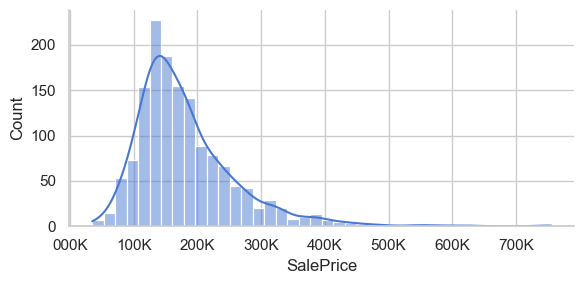

In [495]:
plt.figure(figsize=(10, 10))
sns.displot(df_train["SalePrice"] / 100000, bins=40, kde=True, height=3, aspect=2)
plt.xticks(ticks=[i for i in range(0, 8)], labels=[f"{i}00K" for i in range(0, 8)])
plt.show()

☝🏻 Careful -> skewed distribution of price

- In statistical analysis, a non-skewed distribution is typically a normal distribution, which resembles a bell curve when graphed. This means it's symmetric, with most of the observations clustering around the central peak and the probabilities for values further away from the mean tapering off equally in both directions.

- If we don't apply a log transformation to SalePrice when it's skewed, your model may not perform as well, especially if it assumes that the residuals (errors) are normally distributed, as many linear models do. Applying a log transformation can help stabilize the variance across the data range and make the data conform more closely to the assumptions of parametric statistical tests, leading to more reliable statistical inference and potentially better model performance. If a log transformation is applied, the distribution should look more like a normal distribution, with fewer outliers and a more symmetric shape.

- When should log **NOT** be applied to the target variable?
  - The distribution of the target variable is already close to normal. Log transformation in such cases might lead to a worse fit.
  - The model you're using is robust to non-normality, like tree-based models (e.g., decision trees, random forests).
  - The range of the target variable is narrow with low variance, so the proportional differences are minimal.
  - You have a binary or categorical target variable. In classification problems, log transformation is not applicable.
  - The relationship between predictors and the target is linear, and there are no signs of heteroscedasticity (uneven spread of residuals).

### Data cleaning & Preprocessing

In [496]:
# TODO: ** `LotFrontage` NEEDS TO BE HANDLED
# TODO: apply all this transformations for train & test datasets, and then split again
# TODO: remove outliers
# TODO: remove prices above 4500 sq?
# TODO: make boxcox run! (maybe just for a few ft.?)

# remove features with very low variance
df_train.drop(
    ["Street", "Utilities", "PoolQC", "LotFrontage"],
    axis=1,
    inplace=True,
)

# convert numerical (but actually categorical) features to str
df_train[["MSSubClass", "YrSold", "MoSold"]] = df_train[
    ["MSSubClass", "YrSold", "MoSold"]
].astype(str)


# fill NA with default values
df_train["Fence"] = df_train["Fence"].fillna("NoFence")
df_train["Alley"] = df_train["Alley"].fillna("NoAlleyAccess")
df_train["MiscFeature"] = df_train["MiscFeature"].fillna("None")
df_train["MasVnrType"] = df_train["MasVnrType"].fillna("None")
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("NoFireplace")

# fill NA for garage
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(df_train["YearBuilt"])
garage_columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
df_train[garage_columns] = df_train[garage_columns].fillna("NoGarage")

# fill NA for basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_train[col] = df_train[col].fillna('None')

# fill NA based on most frequent values
df_train["Electrical"] = df_train["Electrical"].fillna(df_train["Electrical"].mode()[0])

In [497]:
show_missing_data(df_train)

Empty DataFrame
Columns: [# missing, % missing]
Index: []


In [498]:
df_train.drop("Id", axis=1, inplace=True)

### Feature Engineering

In [499]:
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

def apply_boxcox(df):
    """
    Apply Box-Cox transformation to numerical features with skewness > 0.5 
    """
    # Assuming 'features' is your DataFrame
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics = [feature for feature in df.columns if df[feature].dtype in numeric_dtypes]

    # Calculate skewness and select highly skewed features
    skewness = df[numerics].apply(lambda x: skew(x.dropna()))
    high_skewness = skewness[abs(skewness) > 0.5]
    high_skew_features = high_skewness.index

    # Apply Box-Cox transformation to highly skewed features
    for feature in high_skew_features:
        # Adding 1 to the feature values to ensure positivity as boxcox1p requires positive values
        df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

In [500]:
# TODO: create new features

### Encoding categorical data

In [501]:
# List of columns to encode
columns_to_encode = df_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()
encoded_df_train = pd.get_dummies(df_train, columns=columns_to_encode, drop_first=True)

### Split dataset into Train/Test data

In [502]:
from sklearn.model_selection import train_test_split

X = encoded_df_train.drop("SalePrice", axis=1)
# X = apply_yeojohnson(df_train.drop("SalePrice", axis=1))
y = encoded_df_train["SalePrice"]

# Applying log transformation
y_log = np.log1p(encoded_df_train["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_STATE
)

### Regression Models

In [503]:
from xgboost import XGBRegressor


def fit_xgb_regressor(
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=1,
    n_estimators=100,
    objective="reg:squarederror",
    reg_alpha=0,
    scale_pos_weight=1,
    subsample=1,
):
    xgb = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective=objective,
        nthread=-1,
        scale_pos_weight=scale_pos_weight,
        seed=RANDOM_STATE,
        reg_alpha=reg_alpha,
    )
    xgb.fit(X_train, y_train)
    return xgb

### Fit Models

In [504]:
# train regressors with default values
xgb = fit_xgb_regressor()

### Evaluation Functions

In [505]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_models(regressors, cv=10):
    results = []
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    for regressor in regressors:
        y_pred = regressor.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_cv = np.sqrt(
            -cross_val_score(
                regressor, X, y_log, scoring="neg_mean_squared_error", cv=kfolds
            )
        )
        results.append(
            {
                "Model": type(regressor).__name__,
                "MAE": mae,
                "MSE": mse,
                "RMSE": rmse,
                "RMSEcv": rmse_cv.mean(),
                "R^2": r2,
            }
        )
    sorted_results = sorted(results, key=lambda x: x["RMSE"], reverse=True)
    print(f"{'Model':<25} {'RMSEcv':<11} {'RMSE':<11} {'MAE':<8} {'MSE':<8} {'R^2':<8}")
    print("-" * 72)
    for result in sorted_results:
        metrics = f"{result['RMSEcv']:<11.5f} {result['RMSE']:<11.5f} "
        metrics += f"{result['MAE']:<8.2f} {result['MSE']:<8.2f} {result['R^2']:<8.2f}"
        print(f"{result['Model']:<25} {metrics}")

In [506]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_learning_curve(
    estimator,
    X= X,
    y = y_log,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    fig_size=(6, 4),
):
    plt.figure(figsize=fig_size)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=n_jobs,
        train_sizes=train_sizes,
    )

    # Take the negative of the scores because 'neg_mean_squared_error' is used
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

    sns.lineplot(x=train_sizes, y=train_scores_mean, label="Training score")
    sns.lineplot(x=train_sizes, y=test_scores_mean, label="Cross-validation score")

    plt.title(f"Learning Curve (RMSE) - {type(estimator).__name__}")
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

In [507]:
from sklearn.model_selection import GridSearchCV


def evaluate_model_grid_search_cv(
    regressor,
    X_train,
    y_train,
    params,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
):
    grid_search = GridSearchCV(
        estimator=regressor, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs
    )
    grid_search.fit(X=X_train, y=y_train)
    best_score = np.sqrt(-grid_search.best_score_)
    best_params = grid_search.best_params_
    print(f"Model: {type(regressor).__name__}")
    print(f" - Best RMSE: {best_score}")
    print(f" - Best params: {best_params}")

### Evaluate Models

In [508]:
models = [xgb]
evaluate_models(models, 2)

Model                     RMSEcv      RMSE        MAE      MSE      R^2     
------------------------------------------------------------------------
XGBRegressor              0.14444     0.15285     0.10     0.02     0.87    


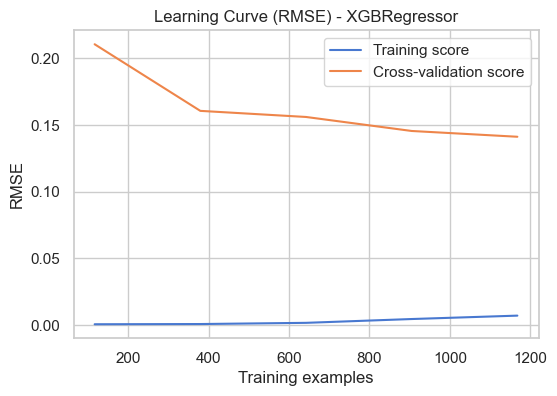

In [509]:
plot_learning_curve(xgb)

### Tune Models

In [510]:
# params = {
#     "colsample_bytree": [0.7],
#     "gamma": [0],
#     "learning_rate": [0.01, 0.05],
#     "max_depth": [2, 3],
#     "min_child_weight": [0],
#     "n_estimators": [2500, 3460],
#     "objective": ["reg:squarederror"],
#     "reg_alpha": [0.00006],
#     "scale_pos_weight": [1],
#     "subsample": [0.7, 0.8],
# }

# evaluate_model_grid_search_cv(xgb, X_train, y_train, params, 5)

In [511]:
# xgb = fit_xgb_regressor(
#     0.01, 3460, 3, 0, 0, 0.7, 0.7, "reg:squarederror", 1, 0.00006
# )  # rmse: 0.12
xgb = fit_xgb_regressor(
    colsample_bytree=0.7,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=0,
    n_estimators=3460,
    objective="reg:squarederror",
    reg_alpha=0.00006,
    scale_pos_weight=1,
    subsample=0.7,
)

In [512]:
models = [xgb]
evaluate_models(models, 10)

Model                     RMSEcv      RMSE        MAE      MSE      R^2     
------------------------------------------------------------------------
XGBRegressor              0.12072     0.13061     0.08     0.02     0.90    


In [513]:
# plot_learning_curve(xgb)